In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels.formula.api as sm

from sklearn import decomposition, preprocessing
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [2]:
df = pd.read_csv('brazil_predi_swaps_all.csv')
# df.set_index('Date',inplace = True)
df.columns
df.shape

(157, 14)

In [3]:
df.rename(columns= {'10Y_USA': 'Y10_USA', '1Y_USA': 'Y1_USA'}, inplace = True)
print(df.shape)

(157, 14)


In [4]:
df.head()

,Dates,PREDI_1M,PREDI_6M,PREDI_1Y,PREDI_2Y,PREDI_5Y,PREDI_7Y,PREDI_10Y,VIX,SELIC,ECON_ACT,Y1_USA,Y10_USA,IPCA
0,27-Jun-25,14.902,14.930,14.716,13.774,13.437,13.580,13.602,16.32,14.90,0.20,3.97,4.29,4.23
1,30-May-25,14.682,14.760,14.556,13.901,13.590,13.785,13.769,18.57,14.65,0.25,4.11,4.41,5.32
2,30-Apr-25,14.441,14.689,14.521,13.726,13.859,13.844,13.845,24.70,14.15,0.20,3.85,4.17,5.53
3,31-Mar-25,14.147,14.942,15.185,14.891,14.859,14.879,14.822,22.28,14.15,0.80,4.03,4.23,5.48
4,28-Feb-25,13.499,14.525,14.882,15.031,14.904,15.166,15.049,19.63,13.15,0.60,4.08,4.24,5.02


In [5]:
df_pca = df[[ 'PREDI_1M','PREDI_6M','PREDI_1Y', 'PREDI_2Y','PREDI_5Y','PREDI_7Y' , 'PREDI_10Y']]
print(df_pca.shape)
df_pca.head()

(157, 7)


,PREDI_1M,PREDI_6M,PREDI_1Y,PREDI_2Y,PREDI_5Y,PREDI_7Y,PREDI_10Y
0,14.902,14.930,14.716,13.774,13.437,13.580,13.602
1,14.682,14.760,14.556,13.901,13.590,13.785,13.769
2,14.441,14.689,14.521,13.726,13.859,13.844,13.845
3,14.147,14.942,15.185,14.891,14.859,14.879,14.822
4,13.499,14.525,14.882,15.031,14.904,15.166,15.049


In [6]:
scaled_data = preprocessing.StandardScaler().fit_transform(df_pca.iloc[:,:])
print(scaled_data.shape)

(157, 7)


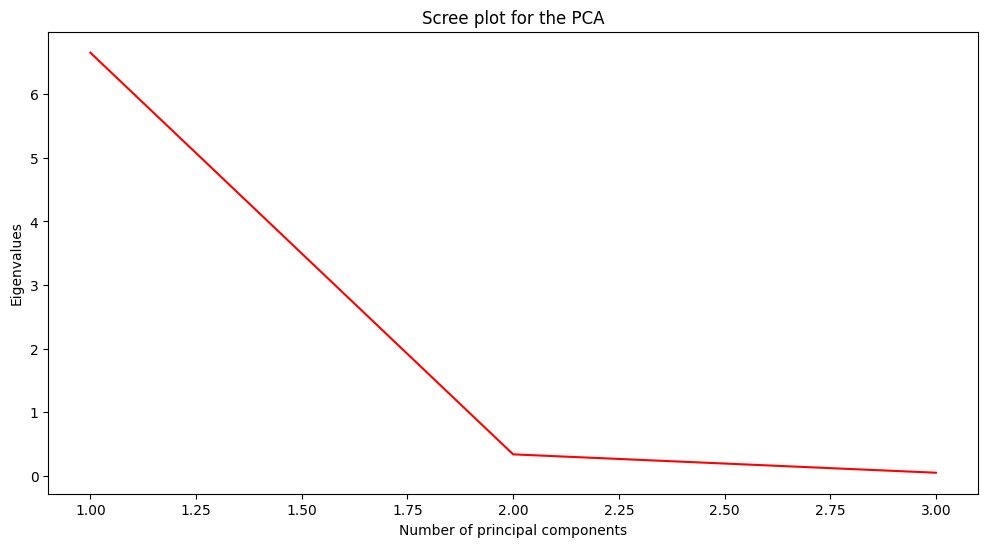

The 1st Principal Component explains 94.4 % of the variance

The 1st and 2nd Principal Components explain 99.2 % of the variance

The 1st, 2nd and 3rd Principal Components explain 99.9 % of the variance



In [7]:
pca = sklearn.decomposition.PCA(n_components=3).fit(scaled_data)

coef_PCA = pca.fit_transform(scaled_data) #coef_PCA = projected Data/ PC scores
plt.figure(figsize=(12, 6))

eig = pca.explained_variance_
var_exp = pca.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for the PCA')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
plt.show()

print ('The 1st Principal Component explains {:03.1f} % of the variance\n'.format(var_exp[0]))
print ('The 1st and 2nd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[1]))
print ('The 1st, 2nd and 3rd Principal Components explain {:03.1f} % of the variance\n'.format(var_exp[2]))

In [8]:
scaled_data.shape

(157, 7)

In [9]:
principal_components = pca.fit_transform(scaled_data)
data_proj = pd.DataFrame(principal_components)
data_proj = data_proj.rename(columns={0: "PC1", 1: "PC2", 2: "PC3"})
data_proj.shape
data_proj.head()

,PC1,PC2,PC3
0,3.334297,0.355246,0.065625
1,3.382979,0.200334,0.077700
2,3.392942,0.093713,0.094576
3,4.113770,-0.412650,-0.001478
4,4.089676,-0.681840,-0.021451


In [10]:
data_proj.shape

(157, 3)

In [11]:
# Eigenvectors (components)
eigenvectors = pca.components_

# Eigenvalues (explained variance)
eigenvalues = pca.explained_variance_

# Calculate loadings
# The loadings matrix is obtained by multiplying each component by the square root of its corresponding eigenvalue.
loadings = eigenvectors.T * np.sqrt(eigenvalues)

In [12]:
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2','PC3'], index= df_pca.columns)
loading_matrix

,PC1,PC2,PC3
PREDI_1M,0.936387,0.334000,0.132266
PREDI_6M,0.974623,0.234640,-0.021132
PREDI_1Y,0.988501,0.133257,-0.103660
PREDI_2Y,0.995723,-0.021655,-0.112682
PREDI_5Y,0.984793,-0.184837,0.007793
PREDI_7Y,0.976718,-0.225169,0.037106
PREDI_10Y,0.966194,-0.258383,0.069856


In [13]:
df['slope'] = df['Y10_USA']- df['Y1_USA']
df = pd.concat([df, data_proj], axis=1, sort=False)
df.shape

(157, 18)

In [14]:
df.iloc[:,1:].corr().round(decimals=2) 

,PREDI_1M,PREDI_6M,PREDI_1Y,PREDI_2Y,PREDI_5Y,PREDI_7Y,PREDI_10Y,VIX,SELIC,ECON_ACT,Y1_USA,Y10_USA,IPCA,slope,PC1,PC2,PC3
PREDI_1M,1.00,0.98,0.95,0.91,0.86,0.84,0.82,-0.25,1.00,-0.05,0.36,0.55,0.47,-0.08,0.93,0.33,0.13
PREDI_6M,0.98,1.00,0.99,0.96,0.91,0.89,0.87,-0.21,0.97,-0.04,0.32,0.54,0.57,-0.02,0.97,0.23,-0.02
PREDI_1Y,0.95,0.99,1.00,0.99,0.94,0.93,0.91,-0.19,0.94,-0.04,0.28,0.52,0.61,0.03,0.99,0.13,-0.10
PREDI_2Y,0.91,0.96,0.99,1.00,0.98,0.97,0.95,-0.21,0.89,-0.04,0.22,0.51,0.61,0.12,0.99,-0.02,-0.11
PREDI_5Y,0.86,0.91,0.94,0.98,1.00,1.00,0.99,-0.21,0.85,-0.05,0.22,0.52,0.54,0.13,0.98,-0.18,0.01
PREDI_7Y,0.84,0.89,0.93,0.97,1.00,1.00,1.00,-0.20,0.83,-0.05,0.22,0.51,0.53,0.13,0.97,-0.22,0.04
PREDI_10Y,0.82,0.87,0.91,0.95,0.99,1.00,1.00,-0.19,0.81,-0.05,0.20,0.50,0.53,0.14,0.96,-0.26,0.07
VIX,-0.25,-0.21,-0.19,-0.21,-0.21,-0.20,-0.19,1.00,-0.27,-0.14,-0.07,-0.26,0.10,-0.14,-0.21,-0.06,-0.16
SELIC,1.00,0.97,0.94,0.89,0.85,0.83,0.81,-0.27,1.00,-0.05,0.36,0.55,0.45,-0.08,0.92,0.34,0.16
ECON_ACT,-0.05,-0.04,-0.04,-0.04,-0.05,-0.05,-0.05,-0.14,-0.05,1.00,0.09,0.06,-0.05,-0.09,-0.05,0.00,-0.04


In [15]:
PREDI_1M_model = sm.ols(formula="PREDI_1M ~ PC1 + PC2 + PC3 ", data=df).fit()
PREDI_1M_params = PREDI_1M_model.params

PREDI_6M_model = sm.ols(formula="PREDI_6M ~ PC1 + PC2 + PC3 ", data=df).fit()
PREDI_6M_params = PREDI_6M_model.params

PREDI_1Y_model = sm.ols(formula="PREDI_1Y ~ PC1 + PC2 + PC3 ", data=df).fit()
PREDI_1Y_params = PREDI_1Y_model.params

PREDI_2Y_model = sm.ols(formula="PREDI_2Y ~ PC1 + PC2 + PC3 ", data=df).fit()
PREDI_2Y_params = PREDI_2Y_model.params

PREDI_5Y_model = sm.ols(formula="PREDI_5Y ~ PC1 + PC2 + PC3 ", data=df).fit()
PREDI_5Y_params = PREDI_5Y_model.params

PREDI_7Y_model = sm.ols(formula="PREDI_7Y ~ PC1 + PC2 + PC3 ", data=df).fit()
PREDI_7Y_params = PREDI_7Y_model.params

PREDI_10Y_model = sm.ols(formula="PREDI_10Y ~ PC1 + PC2 + PC3 ", data=df).fit()
PREDI_10Y_params = PREDI_10Y_model.params

data = [ 
    ['1M',PREDI_6M_params.PC1.round(2), PREDI_1M_params.PC2.round(2),  PREDI_1M_params.PC3.round(2) ],    
    ['6M',PREDI_6M_params.PC1.round(2), PREDI_6M_params.PC2.round(2),  PREDI_6M_params.PC3.round(2) ],
    ['1Y',PREDI_1Y_params.PC1.round(2), PREDI_1Y_params.PC2.round(2), PREDI_1Y_params.PC3.round(2) ],
    ['2Y',PREDI_2Y_params.PC1.round(2), PREDI_2Y_params.PC2.round(2) ,  PREDI_2Y_params.PC3.round(2)],
    ['5Y',PREDI_5Y_params.PC1.round(2), PREDI_5Y_params.PC2.round(2) ,  PREDI_5Y_params.PC3.round(2) ],
    ['7Y',PREDI_5Y_params.PC1.round(2), PREDI_7Y_params.PC2.round(2) ,  PREDI_7Y_params.PC3.round(2) ],
    ['10Y',PREDI_5Y_params.PC1.round(2), PREDI_10Y_params.PC2.round(2) ,  PREDI_10Y_params.PC3.round(2) ],
       ]
df_pc = pd.DataFrame(data, columns=['Maturity', 'PC1','PC2' ,'PC3' ])
df_pc.set_index('Maturity')

,PC1,PC2,PC3
Maturity,,,
1M,1.41,2.16,2.27
6M,1.41,1.51,-0.36
1Y,1.37,0.82,-1.69
2Y,1.19,-0.12,-1.59
5Y,0.92,-0.77,0.09
7Y,0.92,-0.87,0.38
10Y,0.92,-0.94,0.68


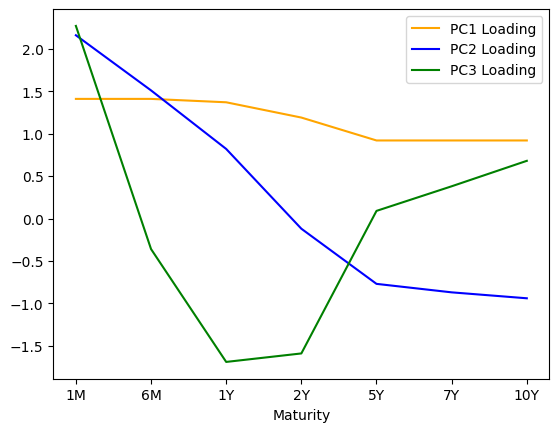

In [16]:
plt.plot(df_pc['Maturity'],df_pc['PC1'], label='PC1 Loading', color='orange', linestyle='-')
plt.plot(df_pc['Maturity'],df_pc['PC2'],  label='PC2 Loading', color='blue', linestyle='-')
plt.plot(df_pc['Maturity'],df_pc['PC3'],  label='PC3 Loading', color='green', linestyle='-')
plt.legend()
plt.xlabel("Maturity")
plt.show()

The first principal component is a roughly equal linear combination of all interest rates, and represents a parallel shift in interest rates.. The second principal component loads positively on short-term rates and negatively on long-term rates, representing the steepness factor. The third principal component loads positively on short and long-term rates, and negatively on medium-term rates, representing the curvature factor.

The third (curvature factor) adds explains very little of total variability in interest rates. As a result, the analysis will focus instead on modeling the first two factors.

# Explaining the level and slope factors with fundamentals

The second step looks for financial and macroeconomic fundamentals that contain explanatory power. This step allows us to see what determines the yield curve at any given point in time.

We model the first (level) and second (slope) PC using OLS regressions using domestic and external macroeconomic variables. The data frequency is monthly and runs from June 2012 to June 2025. The orinal paper work uses data that runs from December 2004 to March 2013. 

Two additional points are worth mentioning.

First, OLS regression estimates are valid only if the variables under study are stationary or, if not, they are at least cointegrated. Running a regression on non- stationary variables that are also not cointegrated may lead to the well-known problem of spurious regressions. Previous academic studies have shown interest rate levels as non-stationary. The slope component is usually a stationary variable since it is basically the spread between two different rates. The same results are obtained here.

The paper tests for stationarity and cointegration. The augmented Dickey-Fuller tests show that the null hypothesis of a unit root cannot be rejected for any of the variables at the 5% confidence level. 

Since all variables appear to have a unit root, they test cointegration usign the Johansen cointegration test for the PC1 level equation. The results show that there is at most one cointegration relation. The cointegration among the variables validates the use of OLS regressions on levels without need to difference them.

In addition to the above, Engle-Granger was used. This method is a two-step approach used for cointegration analysis in time series data. In the first step, it involves estimating a long-run relationship between two or more non-stationary variables using ordinary least squares (OLS). This estimation results in a residual series. The second step tests the stationarity of these residuals using a unit root test, such as the Augmented Dickey-Fuller (ADF) test. If the residuals are found to be stationary, it implies that the variables are cointegrated, meaning they have a long-run equilibrium relationship despite being non-stationary individually.

#### UNIT ROOT TESTS

In [17]:
def adf_test(col_name, per):
    print("ADF Test:", col_name )
    if(per > 0):    
        data = df[[col_name]].diff(periods=-per)
        # Perform the ADF test
        result = adfuller(data.iloc[:-per,:])
    else:
        data = df[[col_name]]
        # Perform the ADF test
        result = adfuller(data)        
    
    # Print the results
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
     
        print(f'\t{key}: {value}')
    
    # Interpret based on p-value
    if result[1] < 0.05:
        print("\nReject the null hypothesis. The time series is likely stationary.")
        print("")
    else:
        print("\nFail to reject the null hypothesis. The time series is likely non-stationary (has a unit root).")
        print("")
        

##### ADF Test

In [18]:
adf_test('PC1',1)
adf_test('IPCA',1)
adf_test('Y10_USA',1)

ADF Test: PC1
ADF Statistic: -4.317000997109731
p-value: 0.00041504447992361874
Critical Values:
	1%: -3.4744158894942156
	5%: -2.880878382771059
	10%: -2.577081275821236

Reject the null hypothesis. The time series is likely stationary.

ADF Test: IPCA
ADF Statistic: -3.6738899323520395
p-value: 0.00449577048281748
Critical Values:
	1%: -3.4769274060112707
	5%: -2.8819726324025625
	10%: -2.577665408088415

Reject the null hypothesis. The time series is likely stationary.

ADF Test: Y10_USA
ADF Statistic: -11.579534284368242
p-value: 2.9659567205405345e-21
Critical Values:
	1%: -3.4732590518613002
	5%: -2.880374082105334
	10%: -2.5768120811654525

Reject the null hypothesis. The time series is likely stationary.



In [19]:
adf_test('PC2',0)
adf_test('VIX',0)
adf_test('SELIC',0)
adf_test('ECON_ACT',0)
adf_test('Y1_USA',0)
adf_test('slope',0)

ADF Test: PC2
ADF Statistic: -3.593174565610536
p-value: 0.005892864130306933
Critical Values:
	1%: -3.4744158894942156
	5%: -2.880878382771059
	10%: -2.577081275821236

Reject the null hypothesis. The time series is likely stationary.

ADF Test: VIX
ADF Statistic: -4.368558202008848
p-value: 0.00033726338205635495
Critical Values:
	1%: -3.4732590518613002
	5%: -2.880374082105334
	10%: -2.5768120811654525

Reject the null hypothesis. The time series is likely stationary.

ADF Test: SELIC
ADF Statistic: -3.292048312815177
p-value: 0.015237678352339301
Critical Values:
	1%: -3.473829775724492
	5%: -2.880622899711496
	10%: -2.5769448985432954

Reject the null hypothesis. The time series is likely stationary.

ADF Test: ECON_ACT
ADF Statistic: -9.368926986997728
p-value: 7.468311597357224e-16
Critical Values:
	1%: -3.4732590518613002
	5%: -2.880374082105334
	10%: -2.5768120811654525

Reject the null hypothesis. The time series is likely stationary.

ADF Test: Y1_USA
ADF Statistic: -2.66471

/var/folders/_n/l_cc5_s108qb3v1_s134kb8w0000gn/T/ipykernel_1462/3593022942.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  plt.plot(pd.to_datetime(df['Dates']), df['PC1'], label='PC1 Loading', color='orange', linestyle='-')
/var/folders/_n/l_cc5_s108qb3v1_s134kb8w0000gn/T/ipykernel_1462/3593022942.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  plt.plot(pd.to_datetime(df['Dates']), df['IPCA'],  label='IPCA', color='blue', linestyle='-')
/var/folders/_n/l_cc5_s108qb3v1_s134kb8w0000gn/T/ipykernel_1462/3593022942.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  plt.

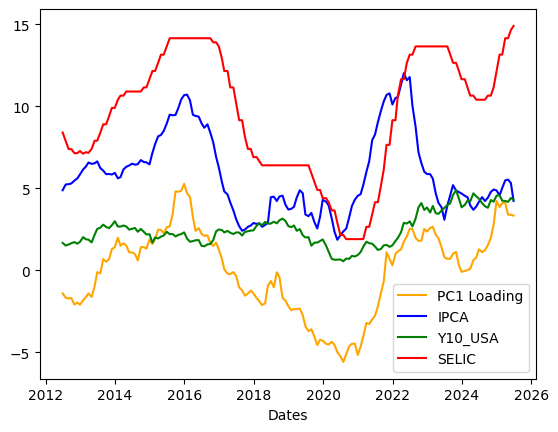

In [20]:
plt.plot(pd.to_datetime(df['Dates']), df['PC1'], label='PC1 Loading', color='orange', linestyle='-')
plt.plot(pd.to_datetime(df['Dates']), df['IPCA'],  label='IPCA', color='blue', linestyle='-')
plt.plot(pd.to_datetime(df['Dates']), df['Y10_USA'],  label='Y10_USA', color='green', linestyle='-')
plt.plot(pd.to_datetime(df['Dates']), df['SELIC'],  label='SELIC', color='red', linestyle='-')
plt.legend()
plt.xlabel("Dates")
plt.show()

### OLS Estimation of PCA

### OLS on PC1

In [21]:
model_pc1 = sm.ols(formula= "PC1 ~ IPCA + Y10_USA + SELIC ",
                   data = df).fit()
print(model_pc1.summary())
X = df[['IPCA','Y10_USA', 'SELIC']]
df['PC1_pred'] = model_pc1.predict(X) 

                            OLS Regression Results                            
Dep. Variable:                    PC1   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     483.4
Date:                Sat, 05 Jul 2025   Prob (F-statistic):           8.35e-78
Time:                        19:21:15   Log-Likelihood:                -186.61
No. Observations:                 157   AIC:                             381.2
Df Residuals:                     153   BIC:                             393.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.5284      0.249    -30.295      0.0

In [22]:
## Residual Analysis
res = adfuller(model_pc1.resid)
if res[1] < 0.05:
    print("\nReject the null hypothesis. The time series is likely stationary.")
    print("\nSince cointegration holds, the OLS results are said to be super-consistent.")
else:
    print("\nFail to reject the null hypothesis. The time series is likely non-stationary (has a unit root).")


Reject the null hypothesis. The time series is likely stationary.

Since cointegration holds, the OLS results are said to be super-consistent.


#### OLS on PC2

In [23]:
model_pc2 = sm.ols(formula= "PC2 ~ SELIC + slope",
                   data = df).fit()
print(model_pc2.params)
print(model_pc2.summary())

X = df[['SELIC', 'slope']]
df['PC2_pred'] = model_pc2.predict(X) 

Intercept   -0.312157
SELIC        0.048620
slope       -0.184194
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    PC2   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     22.53
Date:                Sat, 05 Jul 2025   Prob (F-statistic):           2.62e-09
Time:                        19:21:16   Log-Likelihood:                -116.62
No. Observations:                 157   AIC:                             239.2
Df Residuals:                     154   BIC:                             248.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [24]:
## Residual Analysis
res = adfuller(model_pc2.resid)
if res[1] < 0.05:
    print("\nReject the null hypothesis. The time series is likely stationary.")
    print("\nSince cointegration holds, the OLS results are said to be super-consistent.")
else:
    print("\nFail to reject the null hypothesis. The time series is likely non-stationary (has a unit root).")


Reject the null hypothesis. The time series is likely stationary.

Since cointegration holds, the OLS results are said to be super-consistent.


#### COINTEGRATION TESTS

In [25]:
# Johansen test function
def johansen_test(data, det_order, k_ar_diff=1):
    """
    Performs the Johansen cointegration test and prints the results.
    
    Parameters:
    data: The time series data for the cointegration test.
    det_order (int): The order of the deterministic terms.
                     -1: No constant or trend.
                      0: Constant term only.
                      1: Constant and trend terms.
    k_ar_diff (int): The number of lags to include in the VAR model.
    
    Returns:
    result: The JohansenTestResult object containing test statistics and critical values.
    """
    try:
        result = coint_johansen(data, det_order, k_ar_diff)
        
        print(f'Johansen Test Results (det_order={det_order})')
        print('Trace Statistics:', result.lr1)
        print('Critical Values (Trace):', result.cvt)
        print('Max Eigenvalue Statistics:', result.lr2)
        print('Critical Values (Max Eigenvalue):', result.cvm)
        trace_test_statistic = result.lr1
        critical_values_trace = result.cvt
        print(trace_test_statistic[0] , critical_values_trace[0, 1])
        if trace_test_statistic[0] > critical_values_trace[0, 1]:  # Index 0 for r=0, Index 1 for 5%
            print("(Trace Statistics) Null hypothesis of no cointegration (r=0) rejected at 5% significance.")
        # else:
        #     print("Null hypothesis of no cointegration (r=0) NOT rejected at 5% significance.")
        trace_test_statistic_eig = result.lr2
        critical_values_trace_eig = result.cvm
        print(trace_test_statistic_eig[0] , critical_values_trace_eig[0, 1])
        if trace_test_statistic_eig[0] > critical_values_trace_eig[0, 1]:  # Index 0 for r=0, Index 1 for 5%
            print("(Max Eigenvalue) Null hypothesis of no cointegration (r=0) rejected at 5% significance.")
        # else:
        #     print("Null hypothesis of no cointegration (r=0) NOT rejected at 5% significance.")
        
        print('-----')  
        
        return result

       
    except Exception as e:
        print(f'An error occurred during the Johansen test: {e}')
        return None

In [26]:
data = df[['PC1', 'IPCA', 'Y10_USA', 'SELIC']] 
# Running the test for different deterministic term orders
# for det_order in [-1, 0, 1]:
for det_order in [ 0]:
    johansen_test(data, det_order)

Johansen Test Results (det_order=0)
Trace Statistics: [103.85457359  28.7643765   11.59187866   4.39936243]
Critical Values (Trace): [[44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max Eigenvalue Statistics: [75.09019709 17.17249784  7.19251623  4.39936243]
Critical Values (Max Eigenvalue): [[25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
103.85457358752477 47.8545
(Trace Statistics) Null hypothesis of no cointegration (r=0) rejected at 5% significance.
75.09019708979471 27.5858
(Max Eigenvalue) Null hypothesis of no cointegration (r=0) rejected at 5% significance.
-----


## Estimate fair value of each tenor

The first step uses the fair values of the level and slope factors from the econometric model to assign a fair value to each interest rate tenor.

This is straightforward: using the fair value level and slope factors plus the PCA coefficients, we back out the estimated fair value for each interest rate tenor. Importantly, each fair value interest rate tenor is a linear combination of the fair value of the first two principal components. 



In [27]:
df['PREDI_1M_MA'] = df['PREDI_1M'][::-1].rolling(window=12).mean()
df['PREDI_1M_STD'] = df['PREDI_1M'][::-1].rolling(window=12).std()
df['PREDI_1M_3MSTD'] = df['PREDI_1M'][::-1].rolling(window=3).std()

df['PREDI_6M_MA'] = df['PREDI_6M'][::-1].rolling(window=12).mean()
df['PREDI_6M_STD'] = df['PREDI_6M'][::-1].rolling(window=12).std()
df['PREDI_6M_3MSTD'] = df['PREDI_6M'][::-1].rolling(window=3).std()

df['PREDI_1Y_MA'] = df['PREDI_1Y'][::-1].rolling(window=12).mean()
df['PREDI_1Y_STD'] = df['PREDI_1Y'][::-1].rolling(window=12).std()
df['PREDI_1Y_3MSTD'] = df['PREDI_1Y'][::-1].rolling(window=3).std()

df['PREDI_2Y_MA'] = df['PREDI_2Y'][::-1].rolling(window=12).mean()
df['PREDI_2Y_STD'] = df['PREDI_2Y'][::-1].rolling(window=12).std()
df['PREDI_2Y_3MSTD'] = df['PREDI_2Y'][::-1].rolling(window=3).std()

df['PREDI_5Y_MA'] = df['PREDI_5Y'][::-1].rolling(window=12).mean()
df['PREDI_5Y_STD'] = df['PREDI_5Y'][::-1].rolling(window=12).std()
df['PREDI_5Y_3MSTD'] = df['PREDI_5Y'][::-1].rolling(window=3).std()

df['PREDI_7Y_MA'] = df['PREDI_7Y'][::-1].rolling(window=12).mean()
df['PREDI_7Y_STD'] = df['PREDI_7Y'][::-1].rolling(window=12).std()
df['PREDI_7Y_3MSTD'] = df['PREDI_7Y'][::-1].rolling(window=3).std()

df['PREDI_10Y_MA'] = df['PREDI_10Y'][::-1].rolling(window=12).mean()
df['PREDI_10Y_STD'] = df['PREDI_10Y'][::-1].rolling(window=12).std()
df['PREDI_10Y_3MSTD'] = df['PREDI_10Y'][::-1].rolling(window=3).std()

### Calculate Factor Loadings

In [28]:
df_pred = df.iloc[:-20,:]
df_pred['PREDI_1M_pred'] = df_pred['PREDI_1M_MA'] + (loading_matrix['PC1'][0]* df_pred['PC1'] + loading_matrix['PC2'][0]*df_pred['PC2'])* df_pred['PREDI_1M_STD']
df_pred['PREDI_6M_pred'] = df_pred['PREDI_6M_MA'] + (loading_matrix['PC1'][1]* df_pred['PC1'] + loading_matrix['PC2'][1]*df_pred['PC2'])* df_pred['PREDI_6M_STD']
df_pred['PREDI_1Y_pred'] = df_pred['PREDI_1Y_MA'] + (loading_matrix['PC1'][2]* df_pred['PC1'] + loading_matrix['PC2'][2]*df_pred['PC2'])* df_pred['PREDI_1Y_STD']
df_pred['PREDI_2Y_pred'] = df_pred['PREDI_2Y_MA'] + (loading_matrix['PC1'][3]* df_pred['PC1'] + loading_matrix['PC2'][3]*df_pred['PC2'])* df_pred['PREDI_2Y_STD']
df_pred['PREDI_5Y_pred'] = df_pred['PREDI_5Y_MA'] + (loading_matrix['PC1'][4]* df_pred['PC1'] + loading_matrix['PC2'][4]*df_pred['PC2'])* df_pred['PREDI_5Y_STD']
df_pred['PREDI_7Y_pred'] = df_pred['PREDI_7Y_MA'] + (loading_matrix['PC1'][5]* df_pred['PC1'] + loading_matrix['PC2'][5]*df_pred['PC2'])* df_pred['PREDI_7Y_STD']
df_pred['PREDI_10Y_pred'] = df_pred['PREDI_10Y_MA'] + (loading_matrix['PC1'][6]* df_pred['PC1'] + loading_matrix['PC2'][6]*df_pred['PC2'])* df_pred['PREDI_10Y_STD']

/var/folders/_n/l_cc5_s108qb3v1_s134kb8w0000gn/T/ipykernel_1462/277027566.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_pred['PREDI_1M_pred'] = df_pred['PREDI_1M_MA'] + (loading_matrix['PC1'][0]* df_pred['PC1'] + loading_matrix['PC2'][0]*df_pred['PC2'])* df_pred['PREDI_1M_STD']
/var/folders/_n/l_cc5_s108qb3v1_s134kb8w0000gn/T/ipykernel_1462/277027566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['PREDI_1M_pred'] = df_pred['PREDI_1M_MA'] + (loading_matrix['PC1'][0]* df_pred['PC1'] + loading_matrix['PC2'][0]*df_pred['PC2'])* df_pred['PREDI_1

In [29]:
df_pred.set_index('Dates',inplace = True)
df_pred.index = pd.to_datetime(df_pred.index)

/var/folders/_n/l_cc5_s108qb3v1_s134kb8w0000gn/T/ipykernel_1462/268676612.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pred.index = pd.to_datetime(df_pred.index)


### Compute z-scores of fair value and spot deviations

Finally, the authors use this model to generate a trading rule which is purely quantitative and consistently applied by the model. 

The trading signal the paper uses is a function of the z-score. If the absolute value of the z-score exceeds 1, a buy/sell signal is triggered; if the fair value interest rate is below (above) the spot interest rate by more than 1 standard deviation, then a receiver (payer) signal is issued.  

A z-score is then calculated on this spread time- series, as follows using a three-month rolling window. A three-month investment horizon is the typical an average investor in LatAm fixed income and swap derivative markets considers.

Second, any fair value model is meant to capture trading opportunities by spotting significant deviations between market prices and fair value estimates. The authors compare current market forward prices with future fair value prices derived using in-house forecasts for the fundamental variables. Using forward prices also has the benefit of taking into account the cost of carry of the positions.

The fair value interest rate level x is estimated usign the below written formula. 
- f is the fair value level and slope factors from the econometric model
- c is the first and second factor loading from the PCA
- μ is the historical average of the interest rate level
- σ is the historical standard deviation of the interest rate level
- i is the specific tenor.

The historical average and standard deviation of the interest rate levels are needed since we perform the PCA on the demeaned and normalized dataset. Fair value estimates of slopes are simply the difference of each interest rate fair value.

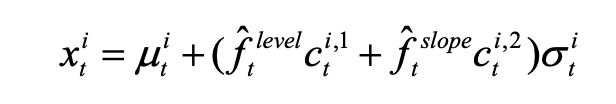

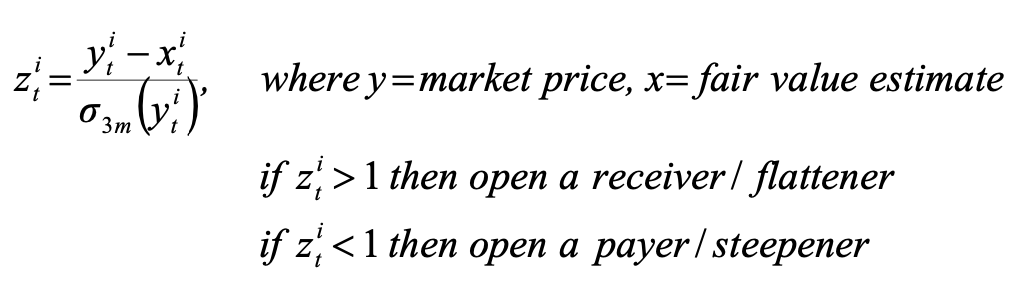

In [30]:
df_pred['PREDI_1M_z'] = (df_pred['PREDI_1M'] - df_pred['PREDI_1M_pred'] ) / df_pred['PREDI_1M_STD'] 
df_pred['PREDI_1M_signal'] = 0
df_pred.loc[df_pred['PREDI_1M_z'] > 1, 'PREDI_1M_signal'] =  1

df_pred['PREDI_6M_z'] = (df_pred['PREDI_6M'] - df_pred['PREDI_6M_pred'] ) / df_pred['PREDI_6M_STD'] 
df_pred['PREDI_6M_signal'] = 0
df_pred.loc[df_pred['PREDI_6M_z'] > 1, 'PREDI_6M_signal'] =  1

df_pred['PREDI_1Y_z'] = (df_pred['PREDI_1Y'] - df_pred['PREDI_1Y_pred']) / df_pred['PREDI_1Y_STD']
df_pred['PREDI_1Y_signal'] = 0
df_pred.loc[df_pred['PREDI_1Y_z'] > 1, 'PREDI_1Y_signal'] =  1

df_pred['PREDI_2Y_z'] = (df_pred['PREDI_2Y'] - df_pred['PREDI_2Y_pred']) / df_pred['PREDI_2Y_STD']
df_pred['PREDI_2Y_signal'] = 0
df_pred.loc[df_pred['PREDI_2Y_z'] > 1, 'PREDI_2Y_signal'] =  1

df_pred['PREDI_5Y_z'] = (df_pred['PREDI_5Y'] - df_pred['PREDI_5Y_pred']) / df_pred['PREDI_5Y_STD']
df_pred['PREDI_5Y_signal'] = 0
df_pred.loc[df_pred['PREDI_5Y_z'] > 1, 'PREDI_5Y_signal'] =  1

df_pred['PREDI_7Y_z'] = (df_pred['PREDI_7Y'] - df_pred['PREDI_7Y_pred']) / df_pred['PREDI_7Y_STD']
df_pred['PREDI_7Y_signal'] = 0
df_pred.loc[df_pred['PREDI_7Y_z'] > 1, 'PREDI_7Y_signal'] =  1

df_pred['PREDI_10Y_z'] = (df_pred['PREDI_10Y'] - df_pred['PREDI_10Y_pred']) / df_pred['PREDI_10Y_STD']
df_pred['PREDI_10Y_signal'] = 0
df_pred.loc[df_pred['PREDI_10Y_z'] > 1, 'PREDI_10Y_signal'] =  1

/var/folders/_n/l_cc5_s108qb3v1_s134kb8w0000gn/T/ipykernel_1462/1967054670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['PREDI_1M_z'] = (df_pred['PREDI_1M'] - df_pred['PREDI_1M_pred'] ) / df_pred['PREDI_1M_STD']
/var/folders/_n/l_cc5_s108qb3v1_s134kb8w0000gn/T/ipykernel_1462/1967054670.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred['PREDI_1M_signal'] = 0
/var/folders/_n/l_cc5_s108qb3v1_s134kb8w0000gn/T/ipykernel_1462/1967054670.py:5: SettingWithCopyWarning: 
A value is trying to 

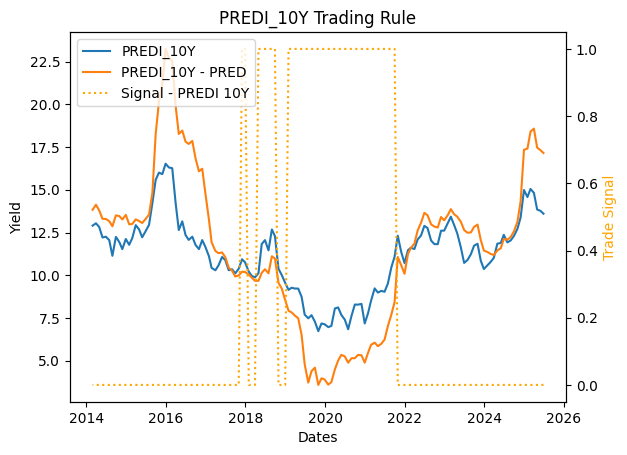

In [31]:
fig, ax1 = plt.subplots()

# Plot the first two lines on the primary y-axis
ax1.plot(df_pred.index, df_pred.PREDI_10Y, label='PREDI_10Y')
ax1.plot(df_pred.index, df_pred.PREDI_10Y_pred, label='PREDI_10Y - PRED')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the third line on the secondary y-axis
ax2.plot(df_pred.index, df_pred.PREDI_7Y_signal, color='orange', label='Signal - PREDI 10Y', linestyle=':')

# Set labels and title
ax1.set_xlabel('Dates')
ax1.set_ylabel('Yield')
ax2.set_ylabel('Trade Signal', color='orange')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.title('PREDI_10Y Trading Rule')
plt.show()

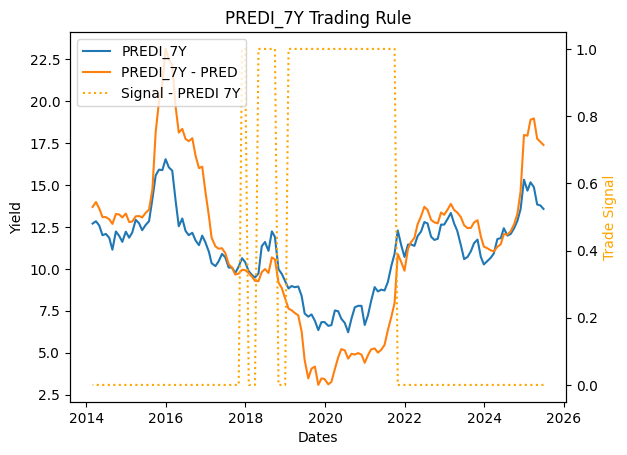

In [32]:
fig, ax1 = plt.subplots()

# Plot the first two lines on the primary y-axis
ax1.plot(df_pred.index, df_pred.PREDI_7Y, label='PREDI_7Y')
ax1.plot(df_pred.index, df_pred.PREDI_7Y_pred, label='PREDI_7Y - PRED')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the third line on the secondary y-axis
ax2.plot(df_pred.index, df_pred.PREDI_7Y_signal, color='orange', label='Signal - PREDI 7Y', linestyle=':')

# Set labels and title
ax1.set_xlabel('Dates')
ax1.set_ylabel('Yield')
ax2.set_ylabel('Trade Signal', color='orange')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.title('PREDI_7Y Trading Rule')
plt.show()

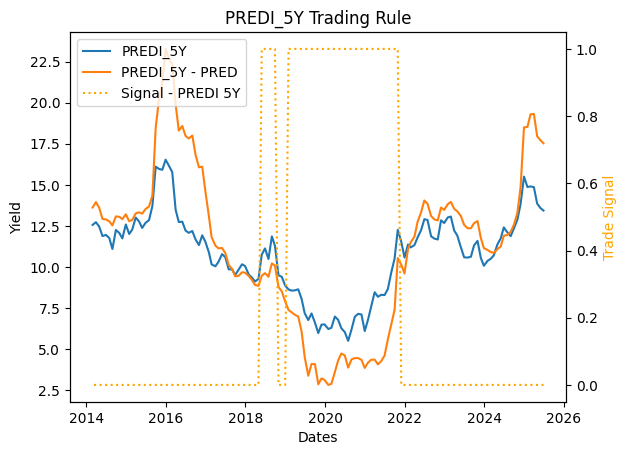

In [33]:
fig, ax1 = plt.subplots()

# Plot the first two lines on the primary y-axis
ax1.plot(df_pred.index, df_pred.PREDI_5Y, label='PREDI_5Y')
ax1.plot(df_pred.index, df_pred.PREDI_5Y_pred, label='PREDI_5Y - PRED')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the third line on the secondary y-axis
ax2.plot(df_pred.index, df_pred.PREDI_5Y_signal, color='orange', label='Signal - PREDI 5Y', linestyle=':')

# Set labels and title
ax1.set_xlabel('Dates')
ax1.set_ylabel('Yield')
ax2.set_ylabel('Trade Signal', color='orange')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.title('PREDI_5Y Trading Rule')
plt.show()

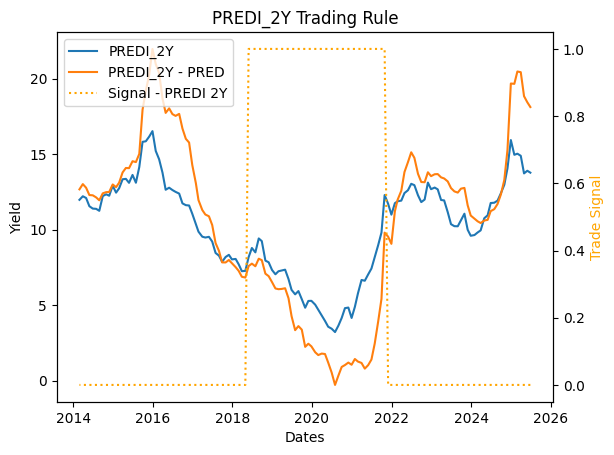

In [34]:
fig, ax1 = plt.subplots()

# Plot the first two lines on the primary y-axis
ax1.plot(df_pred.index, df_pred.PREDI_2Y, label='PREDI_2Y')
ax1.plot(df_pred.index, df_pred.PREDI_2Y_pred, label='PREDI_2Y - PRED')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the third line on the secondary y-axis
ax2.plot(df_pred.index, df_pred.PREDI_2Y_signal, color='orange', label='Signal - PREDI 2Y', linestyle=':')

# Set labels and title
ax1.set_xlabel('Dates')
ax1.set_ylabel('Yield')
ax2.set_ylabel('Trade Signal', color='orange')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.title('PREDI_2Y Trading Rule')
plt.show()

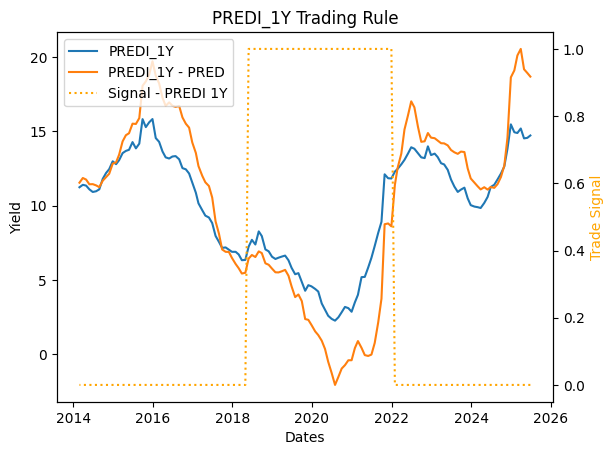

In [35]:
fig, ax1 = plt.subplots()

# Plot the first two lines on the primary y-axis
ax1.plot(df_pred.index, df_pred.PREDI_1Y, label='PREDI_1Y')
ax1.plot(df_pred.index, df_pred.PREDI_1Y_pred, label='PREDI_1Y - PRED')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the third line on the secondary y-axis
ax2.plot(df_pred.index, df_pred.PREDI_1Y_signal, color='orange', label='Signal - PREDI 1Y', linestyle=':')

# Set labels and title
ax1.set_xlabel('Dates')
ax1.set_ylabel('Yield')
ax2.set_ylabel('Trade Signal', color='orange')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.title('PREDI_1Y Trading Rule')
plt.show()

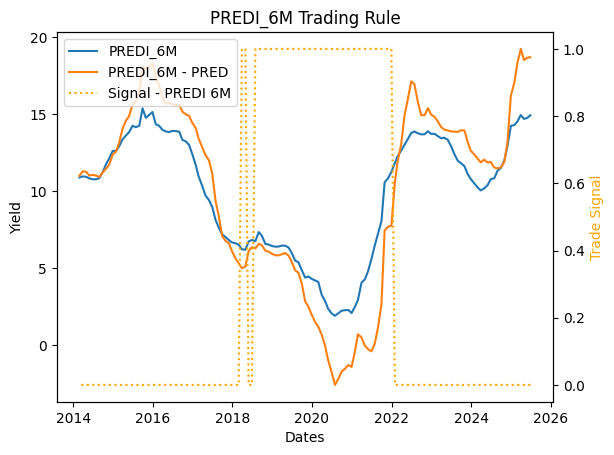

In [36]:
fig, ax1 = plt.subplots()

# Plot the first two lines on the primary y-axis
ax1.plot(df_pred.index, df_pred.PREDI_6M, label='PREDI_6M')
ax1.plot(df_pred.index, df_pred.PREDI_6M_pred, label='PREDI_6M - PRED')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the third line on the secondary y-axis
ax2.plot(df_pred.index, df_pred.PREDI_6M_signal, color='orange', label='Signal - PREDI 6M', linestyle=':')

# Set labels and title
ax1.set_xlabel('Dates')
ax1.set_ylabel('Yield')
ax2.set_ylabel('Trade Signal', color='orange')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Show the plot
plt.title('PREDI_6M Trading Rule')
plt.show()